<a href="https://colab.research.google.com/github/srilamaiti/perosnal_fun_projects/blob/srila/perosnal_fun_projects/income_prediction_ml/income_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.ensemble import RandomForestClassifier

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

Mounted at /content/gdrive


# ***Downloading titanic data set from Kaggle, it will download a zip file from Kaggle platform to Google Colab***

In [2]:
!kaggle datasets download -d mastmustu/income

  0% 0.00/590k [00:00<?, ?B/s]
100% 590k/590k [00:00<00:00, 48.0MB/s]


# ***Unzipping the downaloaded zip files and then remove the actual zip file***

In [3]:
!unzip \*.zip  && rm *.zip

Archive:  income.zip
  inflating: test.csv                
  inflating: train.csv               


In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
df_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income_>50K'],
      dtype='object')

In [6]:
df_train.columns = [c.replace('-','_').replace('>', 'gt_') for c in df_train.columns]
df_test.columns = [c.replace('-','_').replace('>', 'gt_') for c in df_test.columns]
df_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational_num',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income_gt_50K'],
      dtype='object')

# ***EDA and Visualizations***

In [7]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,43957.0,38.617149,13.734401,17.0,28.0,37.0,48.0,90.0
fnlwgt,43957.0,189673.004368,105821.522560,13492.0,117496.0,178100.0,237671.0,1490400.0
educational_num,43957.0,10.074118,2.575092,1.0,9.0,10.0,12.0,16.0
capital_gain,43957.0,1093.559797,7570.536063,0.0,0.0,0.0,0.0,99999.0
capital_loss,43957.0,88.246491,404.588410,0.0,0.0,0.0,0.0,4356.0
hours_per_week,43957.0,40.407694,12.400303,1.0,40.0,40.0,45.0,99.0
income_gt_50K,43957.0,0.239279,0.426648,0.0,0.0,0.0,0.0,1.0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   workclass        41459 non-null  object
 2   fnlwgt           43957 non-null  int64 
 3   education        43957 non-null  object
 4   educational_num  43957 non-null  int64 
 5   marital_status   43957 non-null  object
 6   occupation       41451 non-null  object
 7   relationship     43957 non-null  object
 8   race             43957 non-null  object
 9   gender           43957 non-null  object
 10  capital_gain     43957 non-null  int64 
 11  capital_loss     43957 non-null  int64 
 12  hours_per_week   43957 non-null  int64 
 13  native_country   43194 non-null  object
 14  income_gt_50K    43957 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.0+ MB


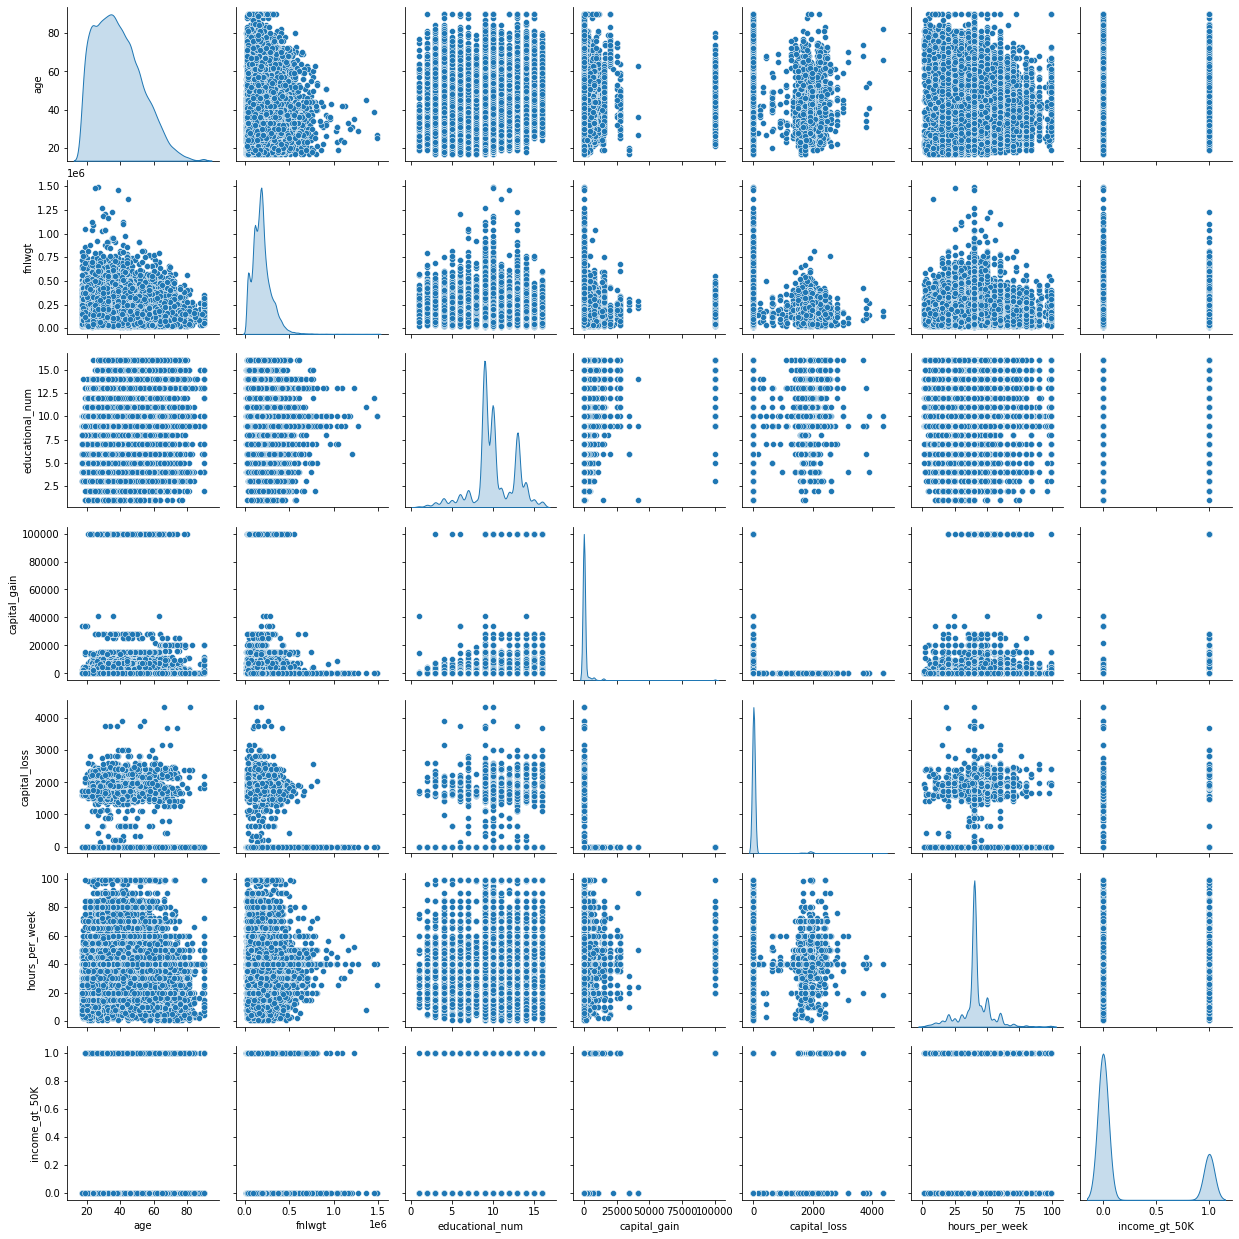

In [9]:
sns.pairplot(df_train, diag_kind = 'kde')

In [10]:
df_train.shape, df_test.shape

((43957, 15), (899, 14))

In [11]:
df_train.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_gt_50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


In [12]:
df_test.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country
0,39,Self-emp-not-inc,327120,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,Portugal
1,32,Private,123253,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,42,United-States
2,47,Private,232628,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Black,Male,0,0,40,United-States
3,19,Private,374262,12th,8,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,20,United-States
4,46,Self-emp-not-inc,311231,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States


In [13]:
# Missing values
df_train.isna().sum()

age                   0
workclass          2498
fnlwgt                0
education             0
educational_num       0
marital_status        0
occupation         2506
relationship          0
race                  0
gender                0
capital_gain          0
capital_loss          0
hours_per_week        0
native_country      763
income_gt_50K         0
dtype: int64

In [14]:
df_train.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational_num     int64
marital_status     object
occupation         object
relationship       object
race               object
gender             object
capital_gain        int64
capital_loss        int64
hours_per_week      int64
native_country     object
income_gt_50K       int64
dtype: object

In [15]:
df_train['workclass'].drop_duplicates()

0                Private
3              State-gov
7       Self-emp-not-inc
17           Federal-gov
18             Local-gov
28          Self-emp-inc
33                   NaN
641         Never-worked
1095         Without-pay
Name: workclass, dtype: object

In [16]:
df_train['native_country'].drop_duplicates()

0                     United-States
7                             Japan
11                            South
21                         Portugal
23                            Italy
37                           Mexico
41                          Ecuador
46                          England
51                      Philippines
56                            China
61                          Germany
72                              NaN
80               Dominican-Republic
83                          Jamaica
93                          Vietnam
137                        Thailand
138                     Puerto-Rico
218                            Cuba
283                           India
367                        Cambodia
370                      Yugoslavia
381                            Iran
471                     El-Salvador
591                          Poland
628                          Greece
717                         Ireland
853                          Canada
1070                      Gu

In [17]:
df_train['occupation'].drop_duplicates()     

0         Exec-managerial
1           Other-service
3        Transport-moving
5            Adm-clerical
6       Machine-op-inspct
7                   Sales
8       Handlers-cleaners
12        Farming-fishing
15        Protective-serv
18         Prof-specialty
22           Craft-repair
33                    NaN
44           Tech-support
109       Priv-house-serv
2642         Armed-Forces
Name: occupation, dtype: object

In [18]:
df_train[(df_train.occupation.isna()) & (df_train.workclass.notnull())]

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_gt_50K
641,17,Never-worked,237272,10th,6,Never-married,NaN,Own-child,White,Male,0,0,30,United-States,0
2040,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,NaN,Wife,Black,Female,0,0,40,United-States,0
13583,20,Never-worked,462294,Some-college,10,Never-married,NaN,Own-child,Black,Male,0,0,40,United-States,0
24860,23,Never-worked,188535,7th-8th,4,Divorced,NaN,Not-in-family,White,Male,0,0,35,United-States,0
29122,17,Never-worked,131593,11th,7,Never-married,NaN,Own-child,Black,Female,0,0,20,United-States,0
30895,18,Never-worked,162908,11th,7,Never-married,NaN,Own-child,White,Male,0,0,35,United-States,0
34548,20,Never-worked,273905,HS-grad,9,Married-spouse-absent,NaN,Other-relative,White,Male,0,0,35,United-States,0
43715,18,Never-worked,206359,10th,6,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,0


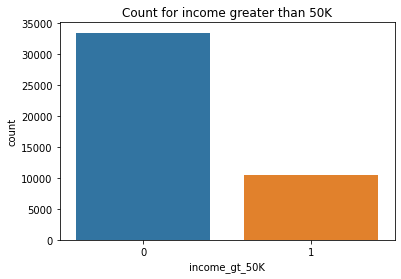

In [19]:
sns.countplot(data=df_train,x='income_gt_50K')
plt.title("Count for income greater than 50K")
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

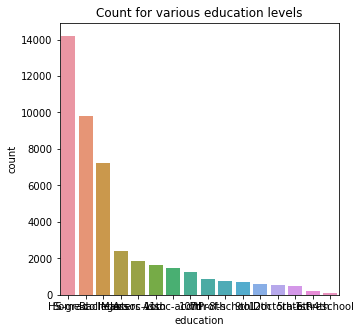

In [20]:
sns.countplot(data = df_train, x = 'education', order = df_train['education'].value_counts().index)
plt.rcParams["figure.figsize"] = (20,20)
plt.title("Count for various education levels")
plt.show()

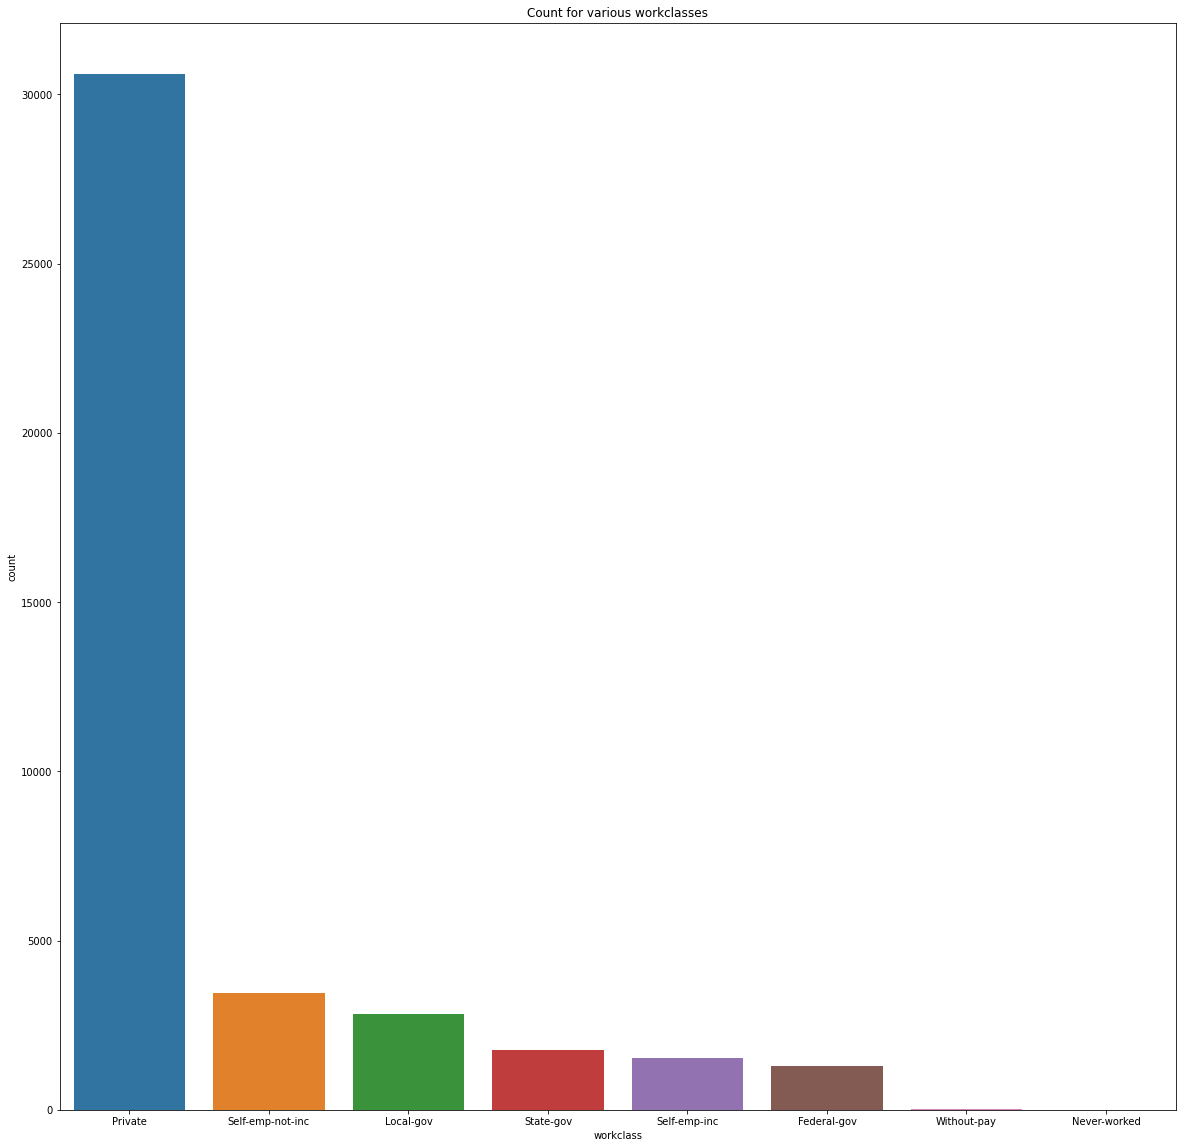

In [21]:
sns.countplot(data = df_train, x = 'workclass', order = df_train['workclass'].value_counts().index)
plt.rcParams["figure.figsize"] = (20,20)
plt.title("Count for various workclasses")
plt.show()

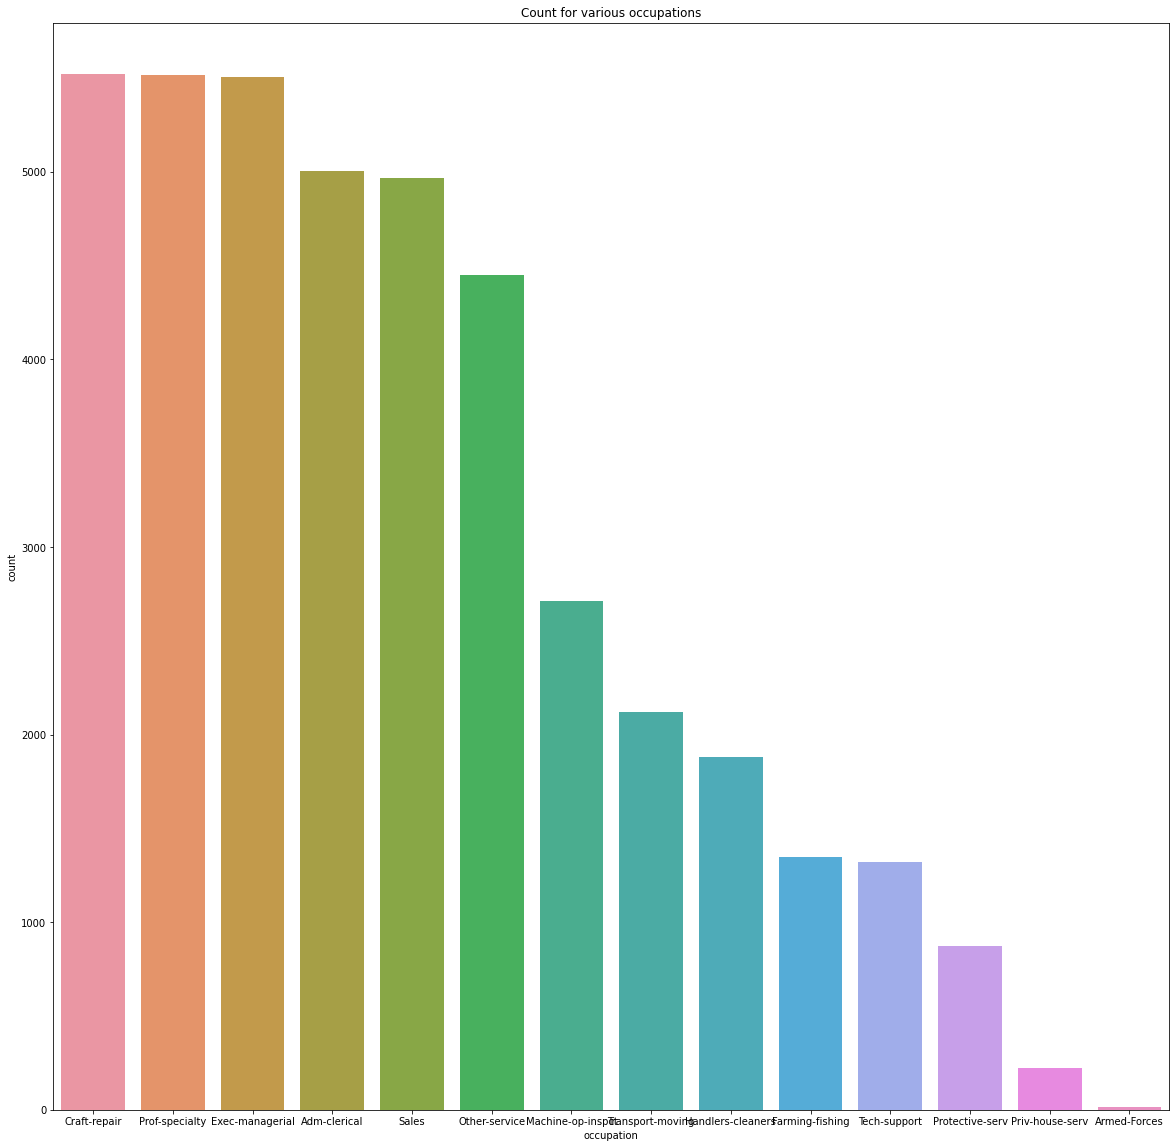

In [22]:
sns.countplot(data = df_train, x = 'occupation', order = df_train['occupation'].value_counts().index)
plt.rcParams["figure.figsize"] = (30,30)
plt.title("Count for various occupations")
plt.show()

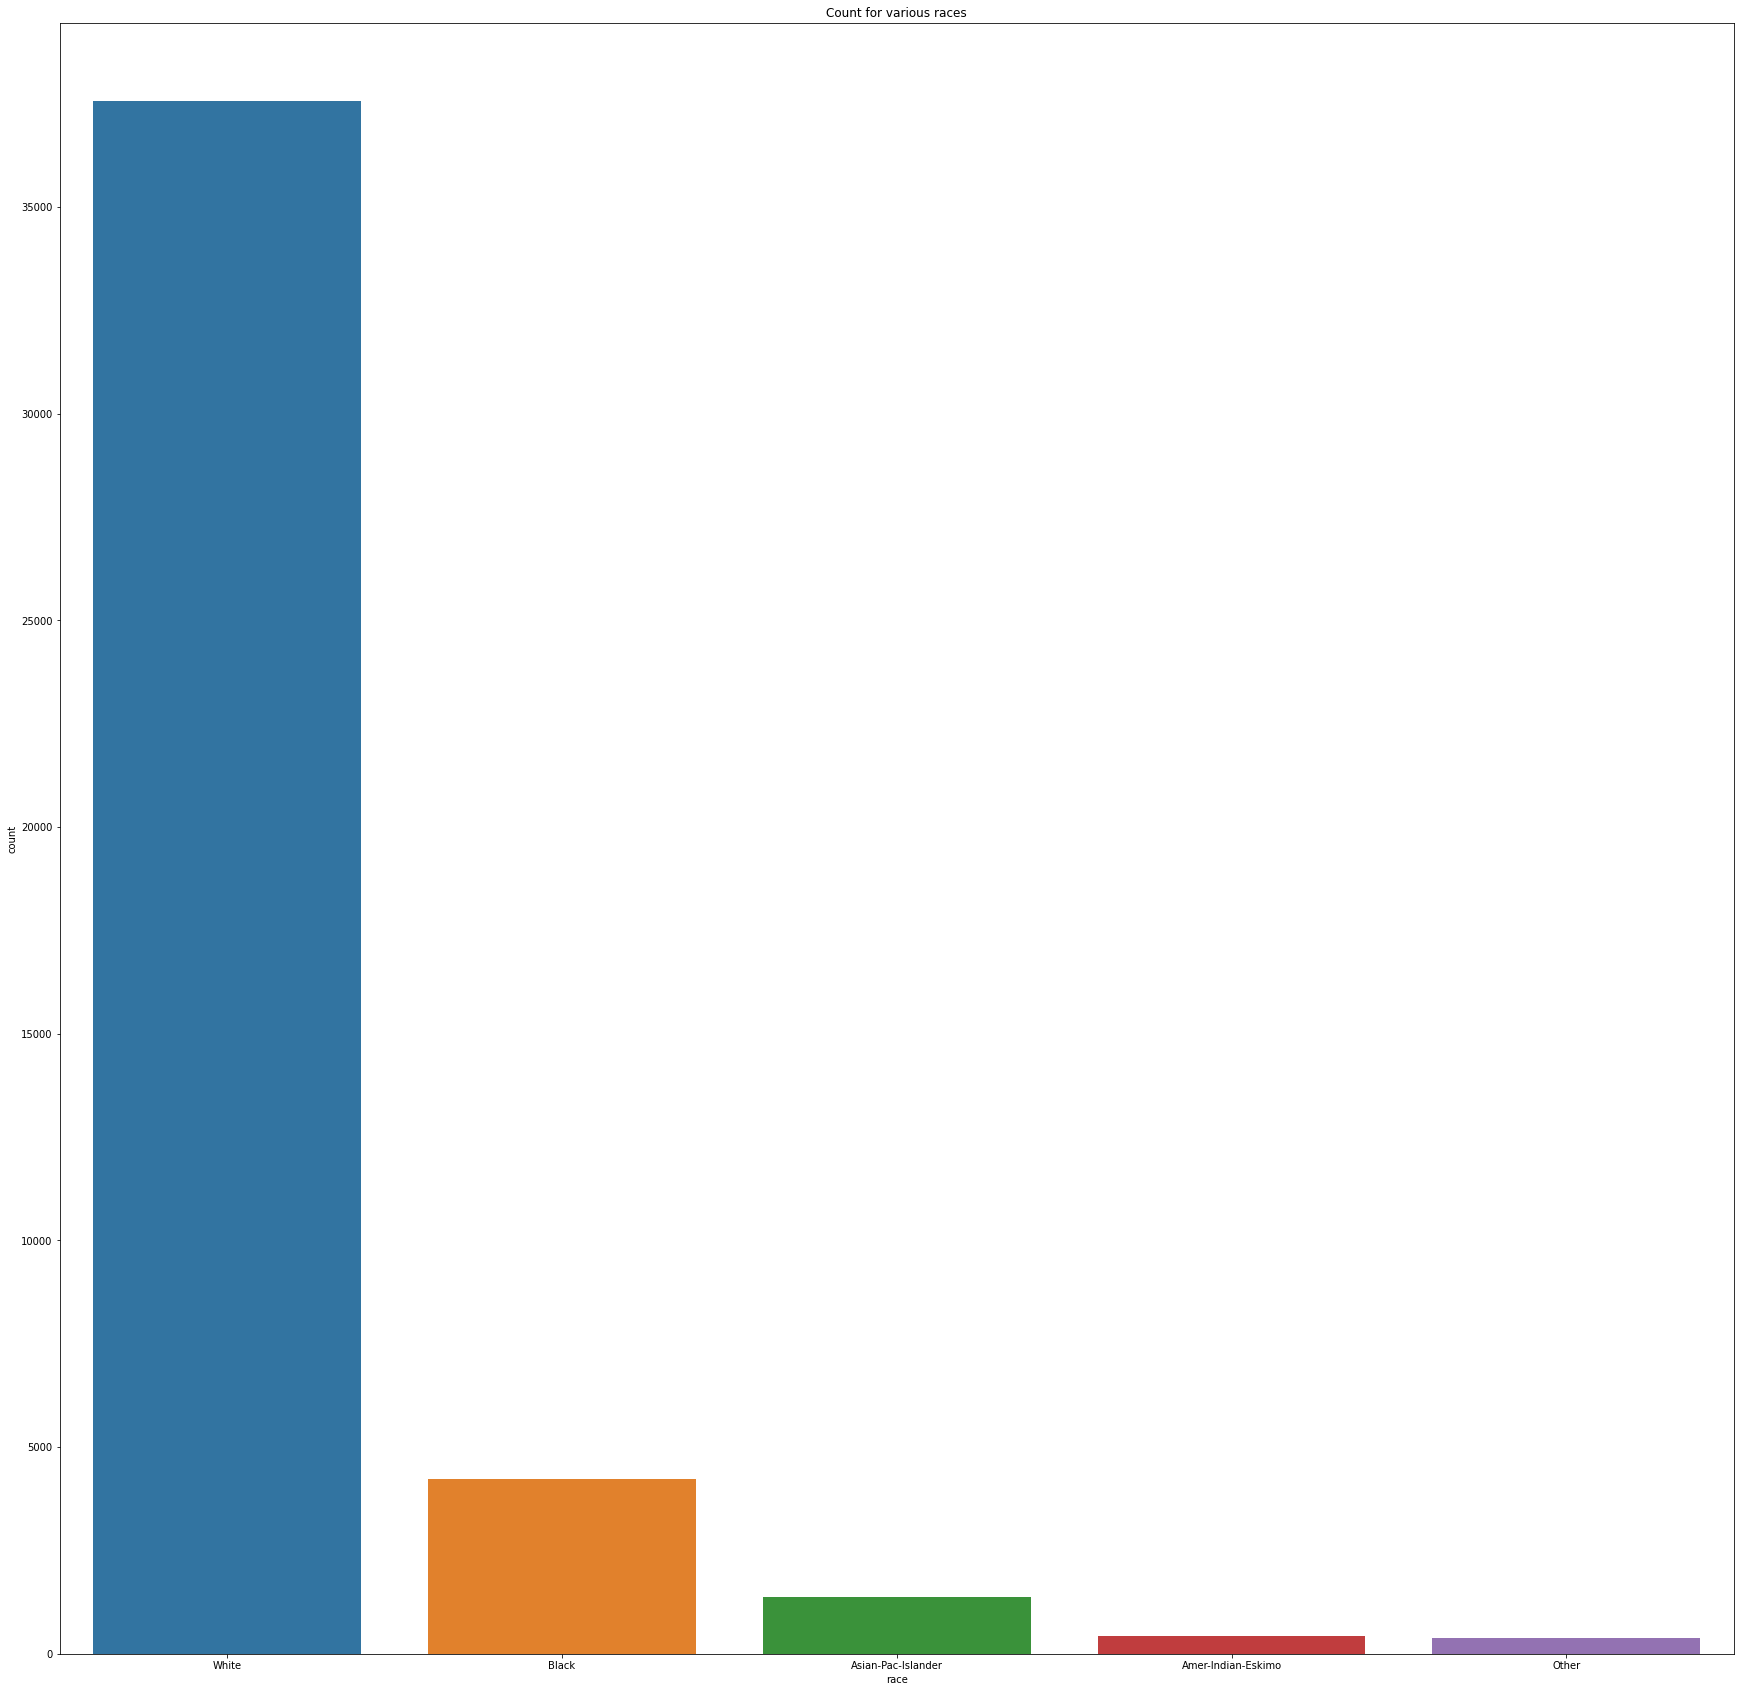

In [23]:
sns.countplot(data = df_train, x = 'race', order = df_train['race'].value_counts().index)
plt.rcParams["figure.figsize"] = (10,10)
plt.title("Count for various races")
plt.show()

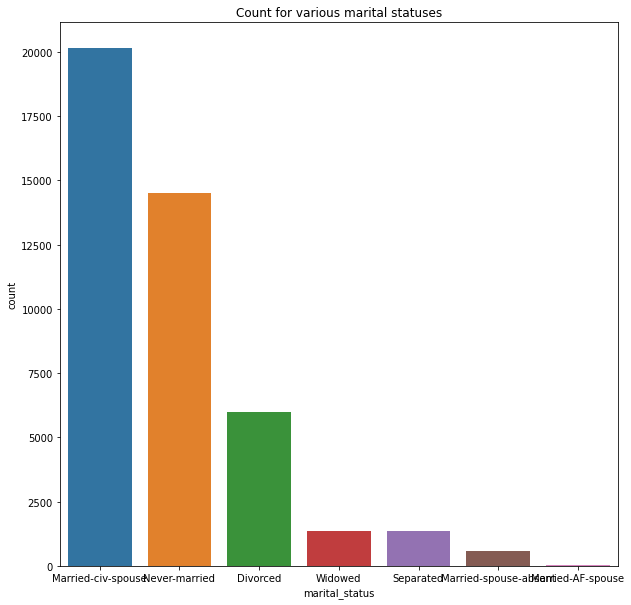

In [24]:
sns.countplot(data = df_train, x = 'marital_status', order = df_train['marital_status'].value_counts().index)
plt.rcParams["figure.figsize"] = (20,20)
plt.title("Count for various marital statuses")
plt.show()

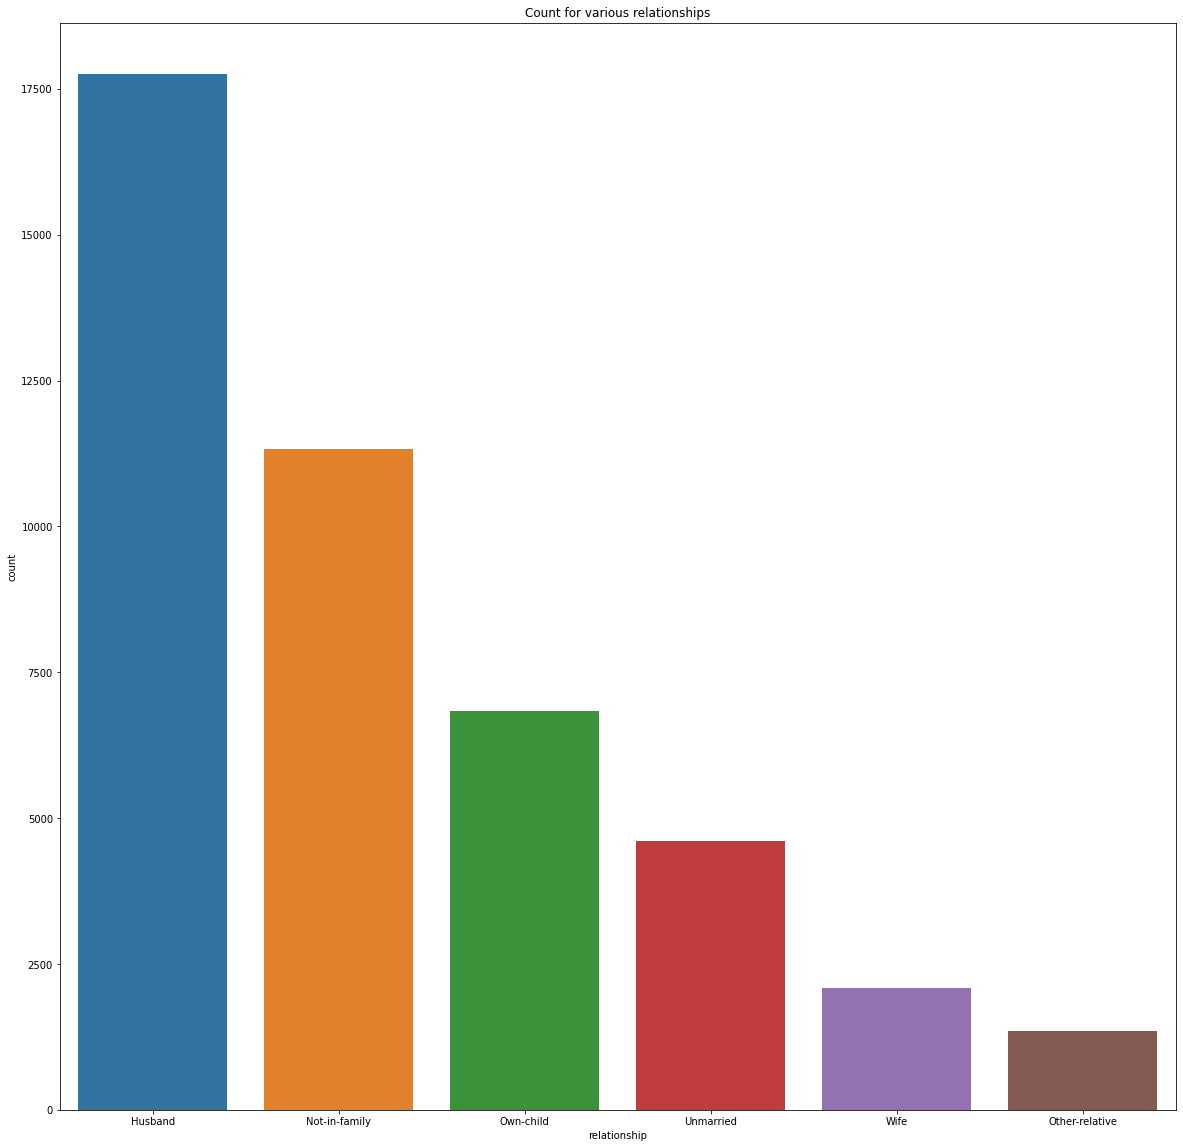

In [25]:
sns.countplot(data = df_train, x = 'relationship', order = df_train['relationship'].value_counts().index)
plt.rcParams["figure.figsize"] = (20,20)
plt.title("Count for various relationships")
plt.show()

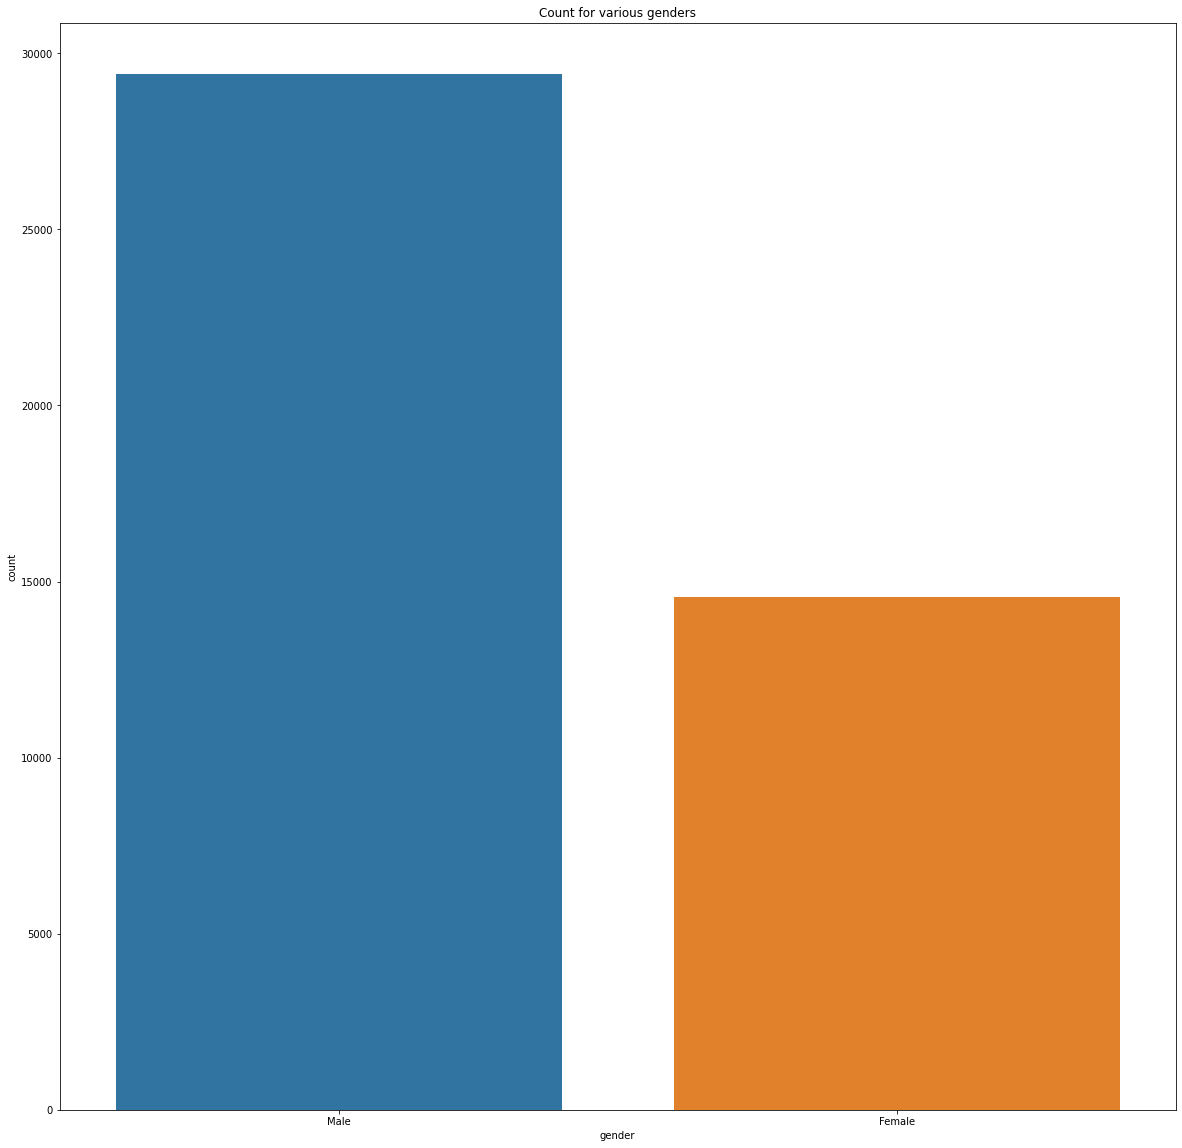

In [26]:
sns.countplot(data = df_train, x = 'gender', order = df_train['gender'].value_counts().index)
plt.rcParams["figure.figsize"] = (20,20)
plt.title("Count for various genders")
plt.show()

In [27]:
df_train = df_train.replace('?', np.nan)
df_test = df_test.replace('?', np.nan)

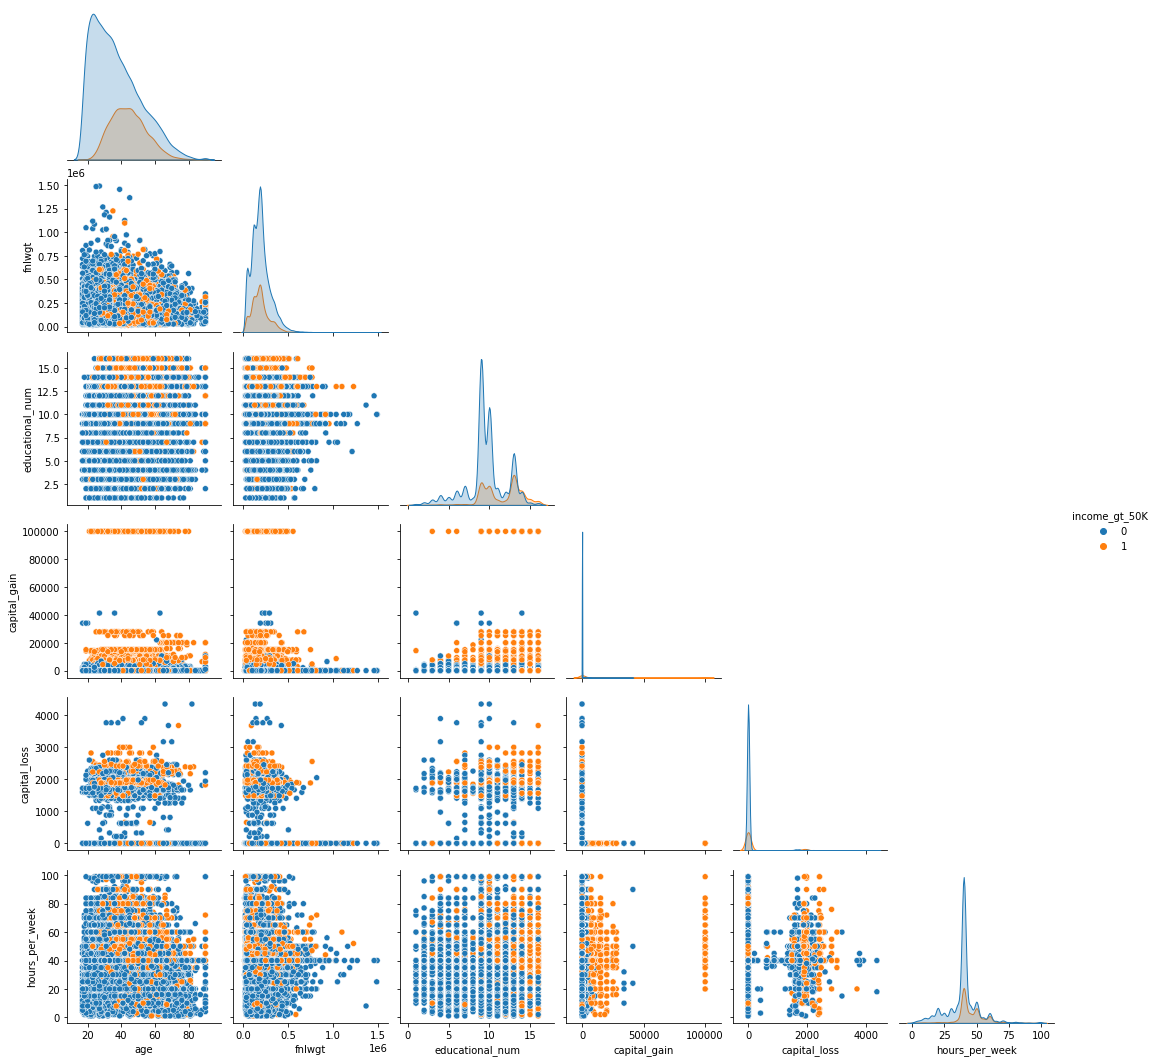

In [28]:
sns.pairplot(df_train, hue = 'income_gt_50K', corner = True)

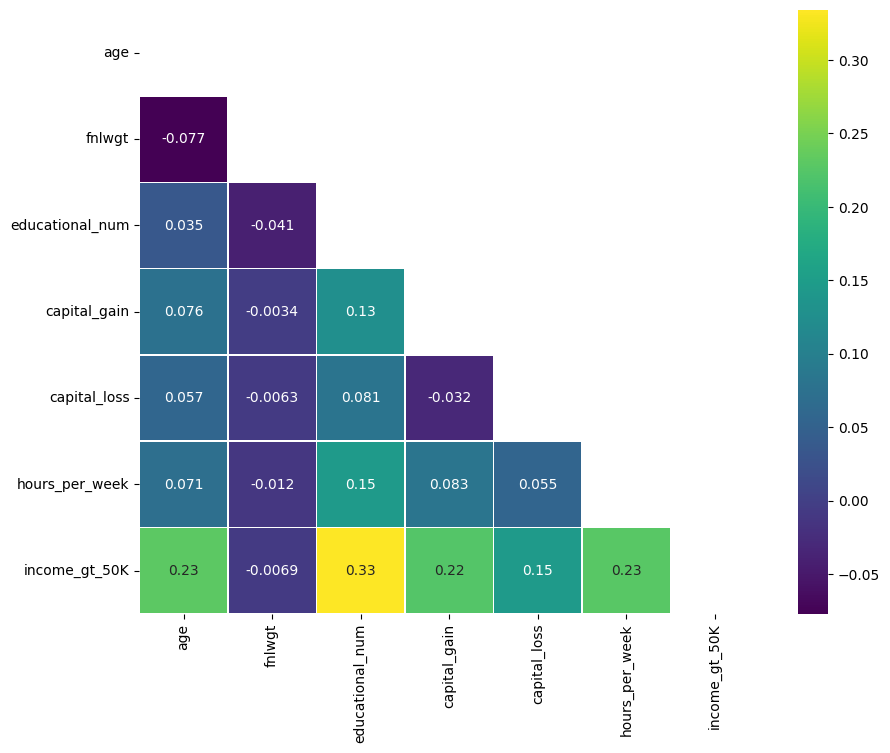

In [29]:
plt.figure(figsize=(10,8),dpi=100)
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(df_train.corr())
sns.heatmap(df_train.corr(), cmap = "viridis", annot = True, linewidth = 0.5, mask = matrix)

Females have more numbers of education for both groups, income greater than 50K and less than 50K.

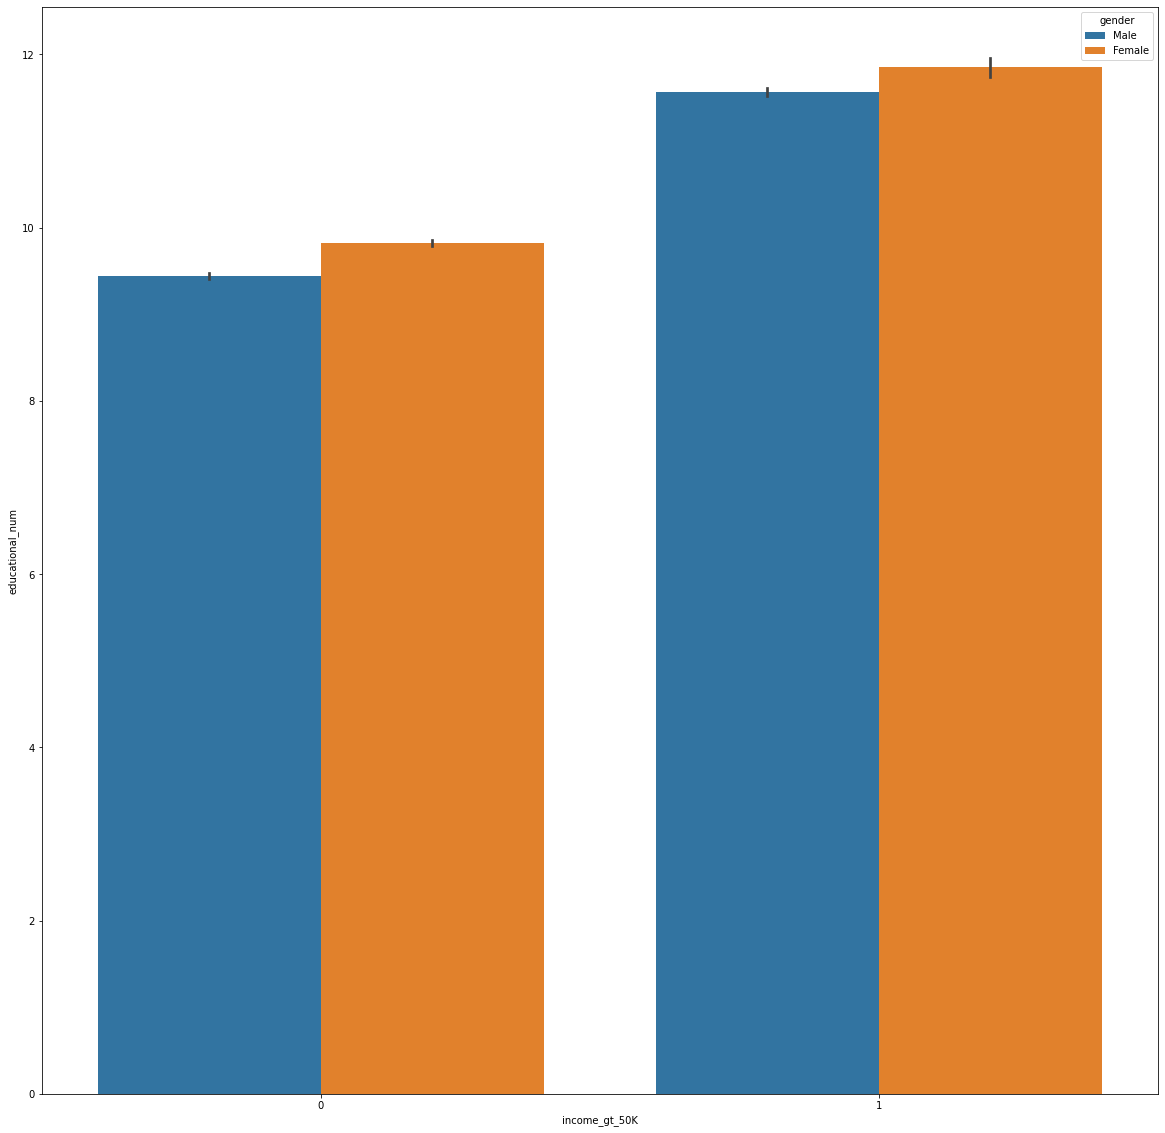

In [30]:
sns.barplot(x = 'income_gt_50K', y = 'educational_num', data = df_train, hue = "gender")

Asia-Pacific islander spend more years in education for both income groups, greater than 50K and otherwise.

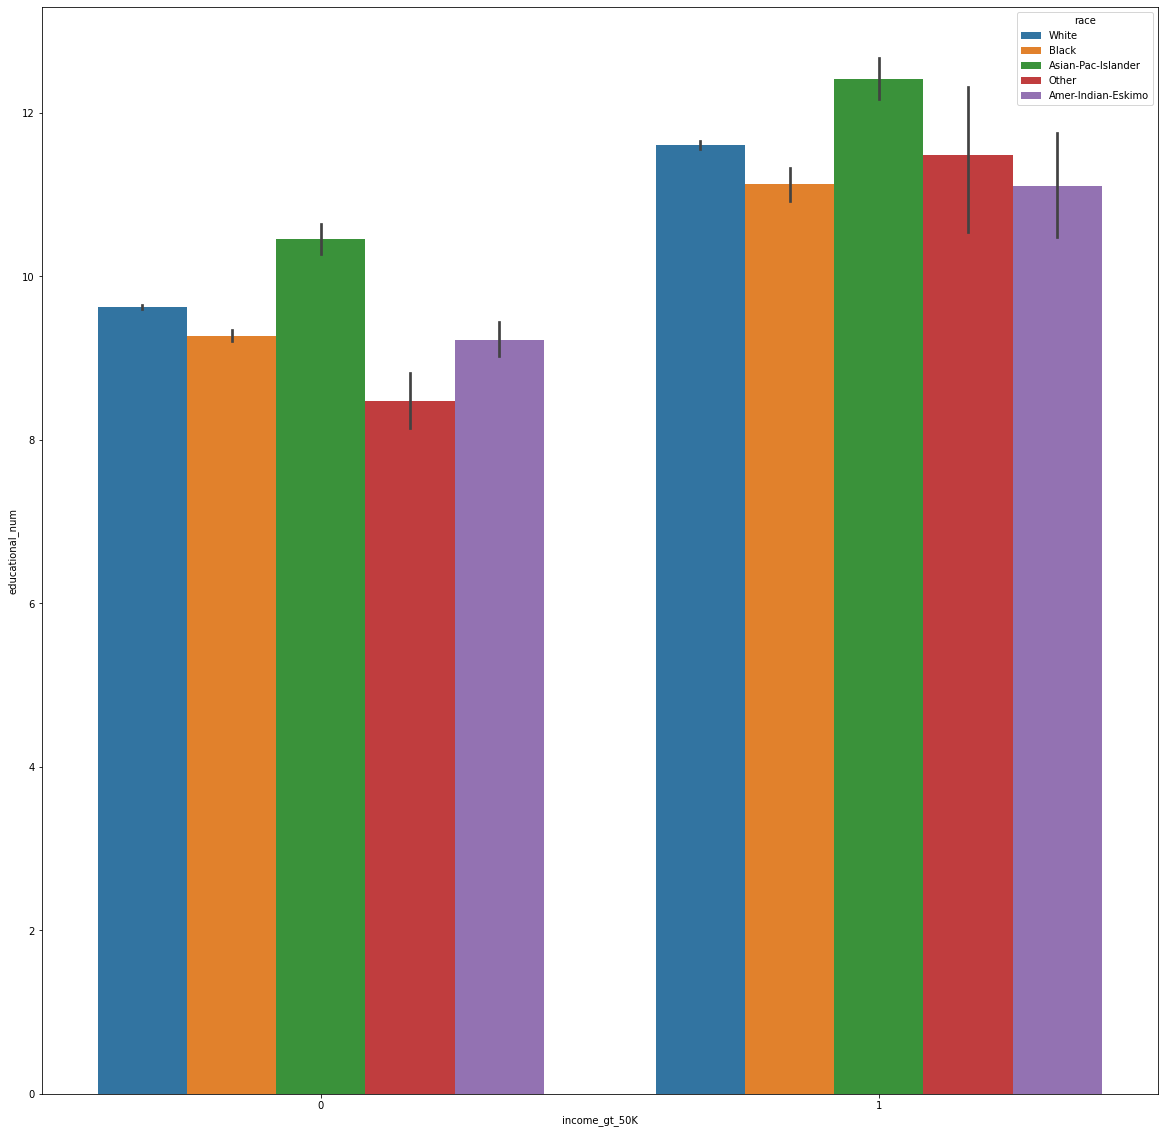

In [31]:
sns.barplot(x = 'income_gt_50K', y = 'educational_num', data = df_train, hue = "race")

In [ ]:
sns.histplot(df_train)
